# Lab Assignment Six: Convolutional Network Architectures

## Dataset Selection
Select a dataset identically to lab two (images). That is, the dataset must be image data. In terms of generalization performance, it is helpful to have a large dataset of identically sized images. It is fine to perform binary classification or multi-class classification.

### I select the image data I used in Lab2. It was got from [kaggle](https://www.kaggle.com/omkargurav/face-mask-dataset). The image datas are collected from google search engine and from Prajna Bhandary's Github repo. I would use 1000 with mask images and another 1000 without mask image as my dataset to do a binary classification task of mask detection. As I said in Lab2, it can be deployed somewhere near the entrance of a shopping mall or hotel to ensure anyone who wants to enter the place to wear a face mask.

## 1. Preparation (3 points total)  
- [1.5 points] Choose and explain what metric(s) you will use to evaluate your algorithm’s performance. You should give a detailed argument for why this (these) metric(s) are appropriate on your data. That is, why is the metric appropriate for the task (e.g., in terms of the business case for the task). Please note: rarely is accuracy the best evaluation metric to use. Think deeply about an appropriate measure of performance.
- [1.5 points] Choose the method you will use for dividing your data into training and testing (i.e., are you using Stratified 10-fold cross validation? Shuffle splits? Why?). Explain why your chosen method is appropriate or use more than one method as appropriate. Convince me that your cross validation method is a realistic mirroring of how an algorithm would be used in practice. 

In [34]:
#import the lib needed
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import shutil
from PIL import Image
from numpy import random
import skimage
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, roc_curve, precision_score, recall_score, f1_score, auc
from sklearn.model_selection import train_test_split
from sklearn import metrics as mt
from sklearn.preprocessing import StandardScaler
from skimage.feature import daisy
from skimage.feature import match_descriptors
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Reshape, Input
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import average
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import  Model
from tensorflow.keras.utils import plot_model


%matplotlib inline
%config InlineBackend.figure_format='retina'
plt.style.use('ggplot')

print("numpy version is:",np.__version__)
print("pandas version is:",pd.__version__)
print("Pillow version is:",Image.__version__)
print("skimage version is:",skimage.__version__)

numpy version is: 1.18.5
pandas version is: 1.2.4
Pillow version is: 8.2.0
skimage version is: 0.18.1


In [35]:
%%time
#Because the image files I got is pre-classfied, to meet the requirement of this assignment, I would put 2048 each of with-mask image files and without-mask image files into another directory. Since the image files are different sizes, I need to pick the size greater than 128*128 and make it as my dataset after resizing.
path_with_masks = "./data/mask_data/with_mask"
path_without_masks = "./data/mask_data/without_mask"
path_train_uniform_dataset = "./data/mask_data/train_uniform_dataset.nosync"

with_masks_prefix = "with_mask_"
without_mask_prefix = "without_mask_"

files_with_masks = os.listdir(path_with_masks)
files_without_masks = os.listdir(path_without_masks)
print("with_mask original size is:",len(files_with_masks))
print("without_mask original size is:",len(files_without_masks))
pick_img_number = 2048
image_uniform_size = [128,128]#the size of image after resizing

if False == os.path.exists(path_train_uniform_dataset):
    os.mkdir(path_train_uniform_dataset)
    count = 0
    for i in range(len(files_with_masks)):
        #convert image file to RGB color
        img_with_mask_tmp = Image.open(os.path.join(path_with_masks,with_masks_prefix+str(i+1)+".jpg"),'r').convert("RGB")
        img_without_mask_tmp = Image.open(os.path.join(path_without_masks,without_mask_prefix+str(i+1)+".jpg"),'r').convert("RGB")
        img_with_mask_tmp = img_with_mask_tmp.resize(image_uniform_size,Image.ANTIALIAS)
        img_without_mask_tmp = img_without_mask_tmp.resize(image_uniform_size,Image.ANTIALIAS)
        img_with_mask_tmp.save(os.path.join(path_train_uniform_dataset,with_masks_prefix+str(i+1)+".jpg"))
        img_without_mask_tmp.save(os.path.join(path_train_uniform_dataset,without_mask_prefix+str(i+1)+".jpg"))
        count += 1
        if (count>=pick_img_number): break

# for img in os.listdir(path_train_uniform_dataset):
print("the dataset is :",len(os.listdir(path_train_uniform_dataset)))

with_mask original size is: 3710
without_mask original size is: 3828
the dataset is : 4096
CPU times: user 3.29 ms, sys: 4.03 ms, total: 7.32 ms
Wall time: 7.13 ms


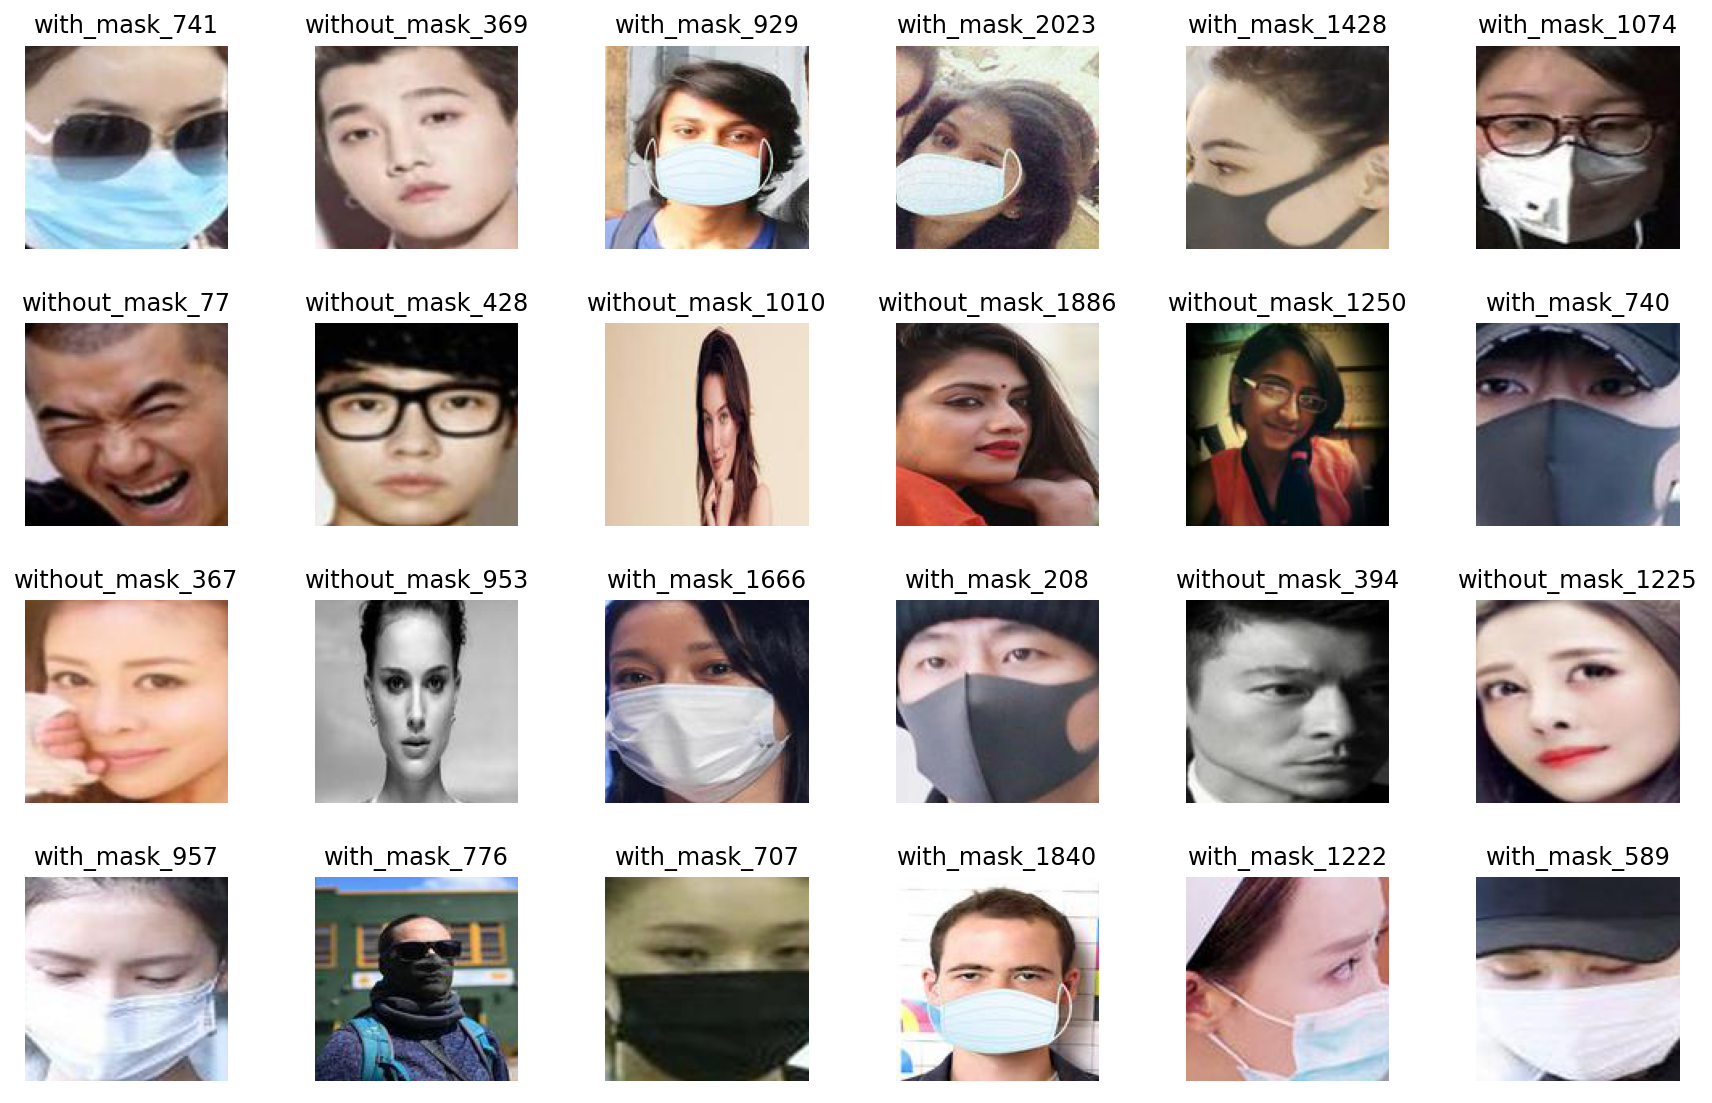

In [36]:
#display several resized images
def plot_raw_gallery(n_row=4, n_col=6):
    plt.figure(figsize=(2*n_col, 2*n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    total = n_row * n_col
    i = 1
    for img_name in os.listdir(path_train_uniform_dataset):
        plt.subplot(n_row, n_col, i)
        img_tmp = plt.imread(os.path.join(path_train_uniform_dataset,img_name))
        plt.imshow(img_tmp)
        plt.title(img_name[:-4], size=12)
        plt.xticks(())
        plt.yticks(())
        i += 1
        if i > total: break

#display a few images resized
plot_raw_gallery()

In [37]:
%%time
train_img_name_list = os.listdir(path_train_uniform_dataset)

X = np.array([np.array(Image.open(os.path.join(path_train_uniform_dataset,img_name))) for img_name in train_img_name_list])#image data
y = np.array([img_name.count("with_mask_") for img_name in train_img_name_list])#target value

print(X.shape)
print(y.shape)

(4096, 128, 128, 3)
(4096,)
CPU times: user 895 ms, sys: 40.3 ms, total: 936 ms
Wall time: 937 ms


### 1.1 Choose and explain what metric(s) you will use to evaluate your algorithm’s performance. You should give a detailed argument for why this (these) metric(s) are appropriate on your data. That is, why is the metric appropriate for the task (e.g., in terms of the business case for the task). Please note: rarely is accuracy the best evaluation metric to use. Think deeply about an appropriate measure of performance.

### I would use accuracy as the metric for my classification task because I have equal number of samples belonging to each class. In terms of even to any class, I can easily get rid of the hassle that a model always says yes all the time which may occur in an imbalanced dataset, though high accuracy.

[2048 2048]


(array([2048.,    0.,    0., 2048.]),
 array([0.  , 0.25, 0.5 , 0.75, 1.  ]),
 <BarContainer object of 4 artists>)

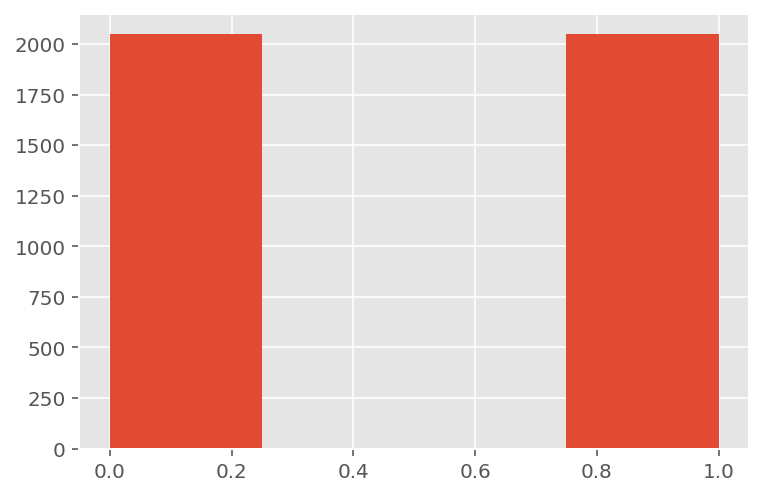

In [38]:
print(np.bincount(y))
plt.hist(y,bins=4)

### 1.2 Choose the method you will use for dividing your data into training and testing (i.e., are you using Stratified 10-fold cross validation? Shuffle splits? Why?). Explain why your chosen method is appropriate or use more than one method as appropriate. Convince me that your cross validation method is a realistic mirroring of how an algorithm would be used in practice. 

### I would use 80-20 traning and testing split because it's a totally balanced dataset. I can also do image data augmentation to increase the size of training set. Besides, to improve computational efficiency, I do not use K-fold here though I think it is good idea to evaluate my model. In addition, I also take a look at the maximum, minimum, mean and standard deviation value of my training and testing set. The difference between them is slight, hence I think they would not bother too much. 

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print(X_train.shape)
print(X_train.shape[1:])
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(3276, 128, 128, 3)
(128, 128, 3)
(820, 128, 128, 3)
(3276,)
(820,)


In [40]:
print(np.min(X_train),np.max(X_train),np.mean(X_train),np.std(X_train))
print(np.min(X_test),np.max(X_test),np.mean(X_test),np.std(X_test))

0 255 129.02474981796271 76.09745020721934
0 255 129.10699653935626 75.47321020667289


## 2. Modeling (6 points total)
- [1.5 points]  Setup the training to use data expansion in Keras. Explain why the chosen data expansion techniques are appropriate for your dataset. 
- [2 points] Create a convolutional neural network to use on your data using Keras. Investigate at least two different convolutional network architectures (and investigate changing some parameters of each architecture--at minimum have two variations of each network for a total of four models trained). Use the method of train/test splitting and evaluation metric that you argued for at the beginning of the lab. Visualize the performance of the training and validation sets per iteration (use the "history" parameter of Keras).
- [1.5 points] Visualize the final results of the CNNs and interpret the performance. Use proper statistics as appropriate, especially for comparing models. 
- [1 points] Compare the performance of your convolutional network to a standard multi-layer perceptron (MLP) using the receiver operating characteristic and area under the curve. Use proper statistical comparison techniques.  

### 2.1 Setup the training to use data expansion in Keras. Explain why the chosen data expansion techniques are appropriate for your dataset.

### I use rescale to normalize the image dataset, rotation_range to roatate a little angle, width_shift_range and height_shift_range to control the amount of of horizontal and vertical shift respectively, zoom_range to randomly zoom the image in, horizontal_flip to randomly flip inputs horizontally, because, in pratice, the image of face photo taken by the machine may not be unified. People usually don't just sit or stand still waiting for shot by the machine so the face photos taken may look like different from standard photos such as Passport photos.

In [41]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_data_gen = ImageDataGenerator(
    rescale = 1.0/255,
    rotation_range = 15,
    width_shift_range=0.02,
    height_shift_range=0.02,
    zoom_range = [0.8,1.2],
    horizontal_flip = True,
    fill_mode='nearest'
)
test_data_gen = ImageDataGenerator(
    rescale = 1.0/255
)
train_iter = train_data_gen.flow(X_train,y_train,batch_size=32)
test_iter = test_data_gen.flow(X_test,y_test,batch_size=32)

### I show some of the image with mask and without mask after augmentation. It seems well mirroring the pictures taken in the realistic.

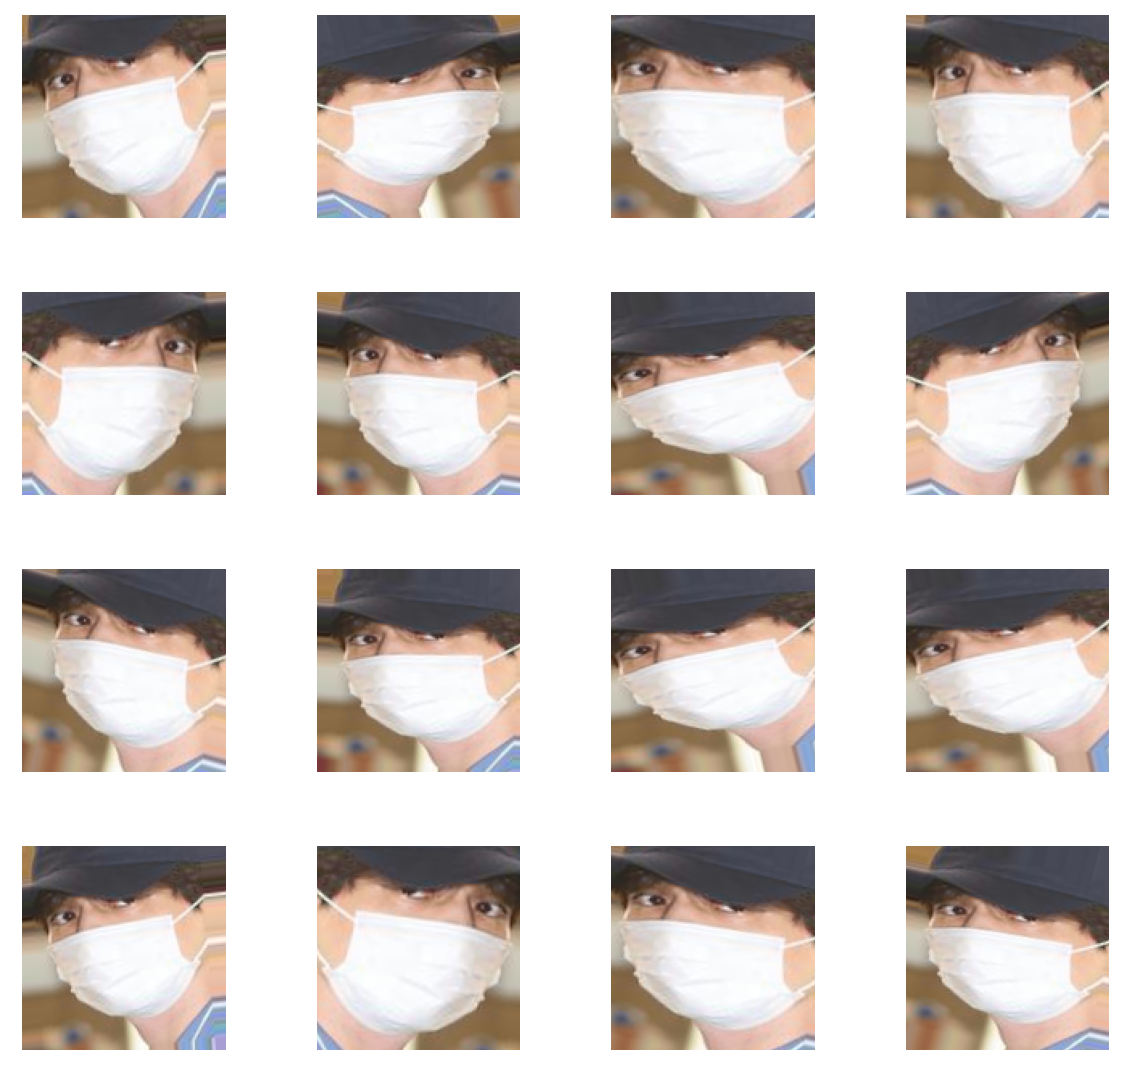

In [42]:
def plot_gallery(iterator,n_row=4, n_col=4):
    plt.figure(figsize=(2*n_col, 2*n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    total = n_row * n_col
    for i in range(total):
        batch  = iterator.next()
        plt.subplot(n_row, n_col, i+1)
        plt.imshow(batch[0])
        plt.xticks(())
        plt.yticks(())

plot_gallery(train_data_gen.flow(np.expand_dims(X[46],0),batch_size=1))

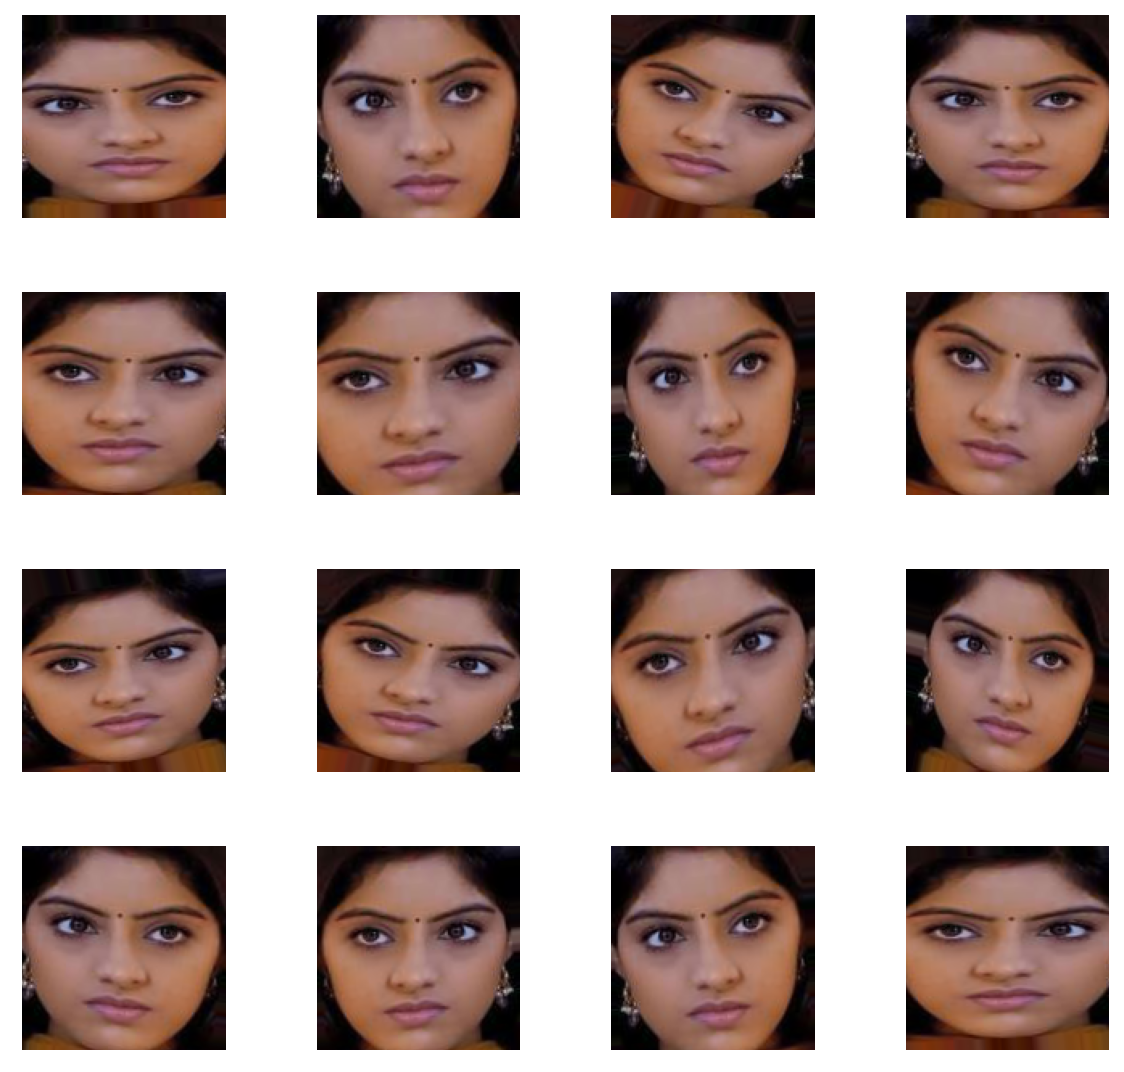

In [43]:
plot_gallery(train_data_gen.flow(np.expand_dims(X[49],0),batch_size=1))

### 2.2 Create a convolutional neural network to use on your data using Keras. Investigate at least two different convolutional network architectures (and investigate changing some parameters of each architecture--at minimum have two variations of each network for a total of four models trained). Use the method of train/test splitting and evaluation metric that you argued for at the beginning of the lab. Visualize the performance of the training and validation sets per iteration (use the "history" parameter of Keras).

### This is cnn model with 1 convolution layer, 1 max pooling, 1 flatten and 2 neural network

In [44]:
%%time

NUM_CLASSES = 1

# make a CNN with conv layer and max pooling
cnn = Sequential() 
cnn.add(
    Conv2D(filters=16, kernel_size=3, strides=1, padding='same', activation='relu',input_shape=(X_train.shape[1:]),data_format="channels_last")
)
cnn.add(MaxPooling2D(pool_size=(2, 2),strides=(2, 2), data_format="channels_last") 
)

# add one layer on flattened output
cnn.add( Flatten() )
cnn.add(Dense(16,activation='relu'))
cnn.add( Dense(NUM_CLASSES,activation='sigmoid') )

cnn.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

cnn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 128, 128, 16)      448       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 16)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 65536)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                1048592   
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 1,049,057
Trainable params: 1,049,057
Non-trainable params: 0
_________________________________________________________________
CPU times: user 17.7 ms, sys: 12 ms, total: 29.7 ms
Wall time: 28.8 ms


In [45]:
def plot_metrics(history,label):
    metrics = ['loss', 'accuracy']
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        # plt.subplot(2,2,n+1)
        plt.plot(history.epoch, history.history[metric], label='Train ' + label)
        plt.plot(history.epoch, history.history['val_'+metric],linestyle="--", label='Val ' + label)
        plt.xlabel('Epoch')
        plt.ylabel(name)
        if metric != 'loss':
            plt.ylim([0,1.1])
        plt.title('{}'.format(metric))
        plt.legend()
        plt.show()

In [46]:
def evaluate_model(model,train_iter,test_iter,y_test,model_name,epochs=10,verbose=0,fit=True): 
    h = None
    if fit:
        h = model.fit(train_iter,
            steps_per_epoch=len(train_iter), 
            epochs=epochs, 
            verbose=verbose,
            shuffle=True,
            callbacks=[EarlyStopping(monitor = 'val_loss', patience = 4)],
            validation_data = test_iter
        )
        plot_metrics(h,model_name)
    # now lets see how well the model performed
    yhat = np.round(model.predict(test_iter).flatten())
    print(yhat.shape)

    print(mt.confusion_matrix(y_test,yhat))
    print(mt.classification_report(y_test,yhat))
    fp,tp,_ = mt.roc_curve(y_test,yhat)
    return {'history':h,'roc':[tp,fp]}

In [47]:
def plot_roc(model1_eval,model2_eval,model1_name,model2_name):
    fp1 = model1_eval['roc'][1]
    tp1 = model1_eval['roc'][0]
    fp2 = model2_eval['roc'][1]
    tp2 = model2_eval['roc'][0]
    plt.plot(100*fp1, 100*tp1, label='{} ROC (AUC {:.3f})'.format(model1_name,auc(fp1,tp1)) , linewidth=2)
    plt.plot(100*fp2, 100*tp2, label='{} ROC (AUC {:.3f})'.format(model2_name,auc(fp2,tp2)), linewidth=2, linestyle='--')
    plt.xlabel('False positives [%]')
    plt.ylabel('True positives [%]')
    # plt.xlim([-0.5,20])
    # plt.ylim([80,100.5])
    plt.grid(True)
    ax = plt.gca()
    # ax.set_aspect('equal')
    plt.legend(loc='best')

Epoch 1/10
103/103 [==============================] - 6s 54ms/step - loss: 0.3594 - accuracy: 0.8495 - val_loss: 0.2218 - val_accuracy: 0.9268
Epoch 2/10
103/103 [==============================] - 5s 53ms/step - loss: 0.2248 - accuracy: 0.9188 - val_loss: 0.2287 - val_accuracy: 0.9122
Epoch 3/10
103/103 [==============================] - 5s 53ms/step - loss: 0.2003 - accuracy: 0.9225 - val_loss: 0.1659 - val_accuracy: 0.9439
Epoch 4/10
103/103 [==============================] - 5s 53ms/step - loss: 0.1864 - accuracy: 0.9304 - val_loss: 0.1552 - val_accuracy: 0.9415
Epoch 5/10
103/103 [==============================] - 5s 53ms/step - loss: 0.1907 - accuracy: 0.9277 - val_loss: 0.1487 - val_accuracy: 0.9463
Epoch 6/10
103/103 [==============================] - 5s 52ms/step - loss: 0.1651 - accuracy: 0.9405 - val_loss: 0.1726 - val_accuracy: 0.9268
Epoch 7/10
103/103 [==============================] - 5s 53ms/step - loss: 0.1657 - accuracy: 0.9371 - val_loss: 0.1336 - val_accuracy: 0.9476

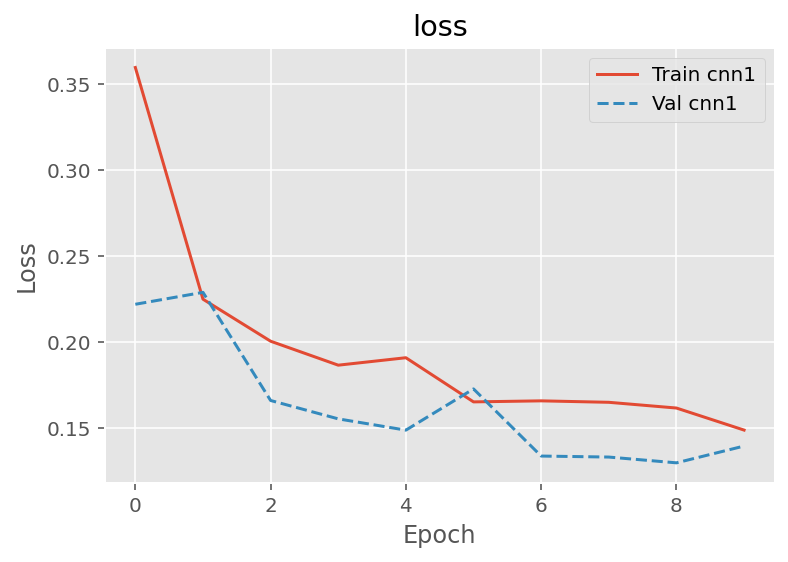

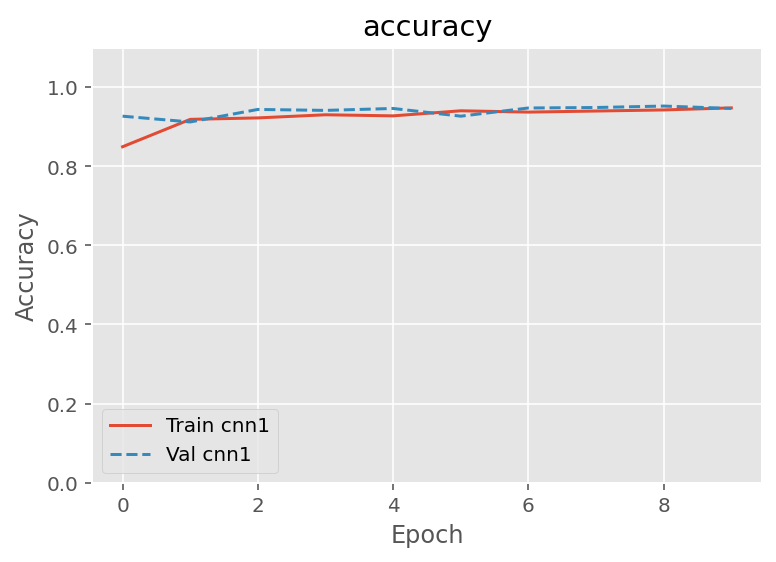

(820,)
[[222 191]
 [215 192]]
              precision    recall  f1-score   support

           0       0.51      0.54      0.52       413
           1       0.50      0.47      0.49       407

    accuracy                           0.50       820
   macro avg       0.50      0.50      0.50       820
weighted avg       0.50      0.50      0.50       820

CPU times: user 1min 6s, sys: 470 ms, total: 1min 6s
Wall time: 55.8 s


In [48]:
%%time
model1_eval = evaluate_model(model=cnn,train_iter=train_iter,test_iter=test_iter,y_test=y_test,model_name = 'cnn1',epochs=10,verbose=1)

### CNN Model 2

In [30]:
cnn2 = Sequential() 
cnn2.add(
    Conv2D(filters=64, kernel_size=3, strides=1, padding='same', activation='relu',input_shape=(X_train.shape[1:]),data_format="channels_last")
)
cnn2.add(
    Conv2D(filters=64, kernel_size=3,strides=1, padding='same', activation='relu', data_format="channels_last")
)
cnn2.add(MaxPooling2D(pool_size=(2, 2),strides=(2, 2), data_format="channels_last") 
)

cnn2.add(
    Conv2D(filters=128, kernel_size=3, strides=1, padding='same', activation='relu',data_format="channels_last")
)
cnn2.add(
    Conv2D(filters=128, kernel_size=3,strides=1, padding='same', activation='relu', data_format="channels_last")
)
cnn2.add(MaxPooling2D(pool_size=(2, 2),strides=(2, 2), data_format="channels_last") 
)

# add one layer on flattened output
cnn2.add( Flatten() )
cnn2.add(Dense(1024,activation='relu'))
cnn2.add(Dropout(0.5))
cnn2.add(Dense(512,activation='relu'))
cnn2.add(Dropout(0.5))
cnn2.add(Dense(256,activation='relu'))
cnn2.add(Dropout(0.5))
cnn2.add( Dense(NUM_CLASSES,activation='sigmoid') )

cnn2.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

cnn2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 128, 128, 64)      1792      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 64, 128)       73856     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 64, 64, 128)       147584    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 128)       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 131072)           

Epoch 1/10
103/103 [==============================] - 18s 178ms/step - loss: 0.7124 - accuracy: 0.4927 - val_loss: 0.6931 - val_accuracy: 0.5098
Epoch 2/10
103/103 [==============================] - 17s 165ms/step - loss: 0.6937 - accuracy: 0.5031 - val_loss: 0.6940 - val_accuracy: 0.4902
Epoch 3/10
103/103 [==============================] - 17s 165ms/step - loss: 0.6936 - accuracy: 0.4976 - val_loss: 0.6933 - val_accuracy: 0.4902
Epoch 4/10
103/103 [==============================] - 17s 165ms/step - loss: 0.6933 - accuracy: 0.5031 - val_loss: 0.6941 - val_accuracy: 0.4902


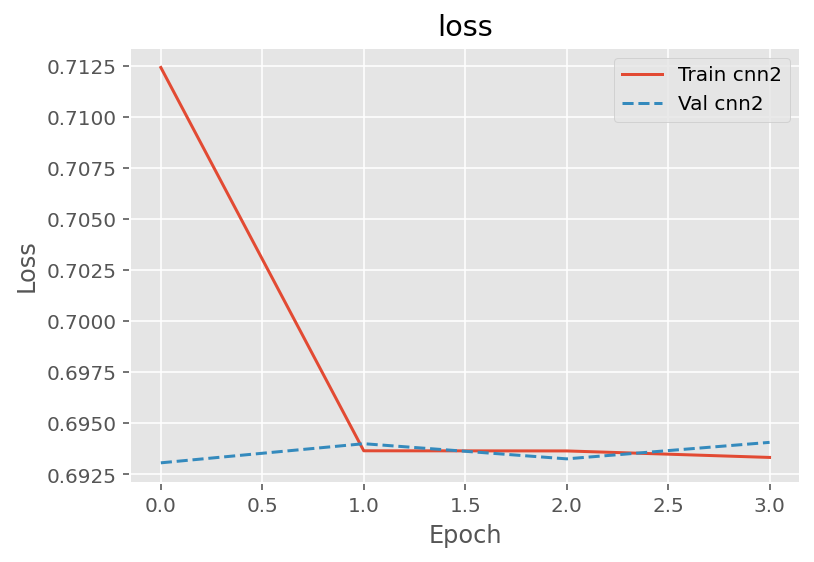

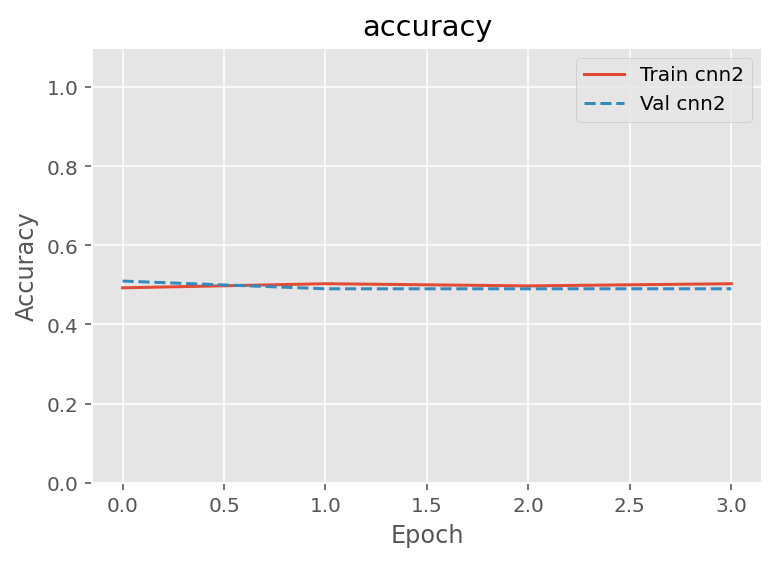

[[402   0]
 [418   0]]
accuracy is : 0.4902439024390244
CPU times: user 1min 19s, sys: 527 ms, total: 1min 19s
Wall time: 1min 13s


In [31]:
%%time
model2_eval = evaluate_model(model=cnn2,train_iter=train_iter,test_iter=test_iter,y_test=y_test,model_name = 'cnn2',epochs=20,verbose=1)

### 2.3 Compare the performance of your convolutional network to a standard multi-layer perceptron (MLP) using the receiver operating characteristic and area under the curve. Use proper statistical comparison techniques.

### This is my MLP model.

In [32]:
%%time

# make a 3 layer keras MLP
mlp = Sequential()
mlp.add( Flatten() ) # make images flat for the MLP input
mlp.add( Dense(input_dim=X_train.shape[1], units=30, 
               activation='relu') )
mlp.add( Dense(units=128, activation='relu') )
mlp.add( Dense(units=64, activation='relu') )
mlp.add( Dense(NUM_CLASSES,activation='sigmoid') )

mlp.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])


CPU times: user 10.6 ms, sys: 38 µs, total: 10.6 ms
Wall time: 9.6 ms


Epoch 1/10
103/103 [==============================] - 5s 53ms/step - loss: 0.6126 - accuracy: 0.7311 - val_loss: 0.5085 - val_accuracy: 0.7500
Epoch 2/10
103/103 [==============================] - 5s 51ms/step - loss: 0.3999 - accuracy: 0.8379 - val_loss: 0.3196 - val_accuracy: 0.8720
Epoch 3/10
103/103 [==============================] - 5s 53ms/step - loss: 0.2957 - accuracy: 0.8855 - val_loss: 0.2643 - val_accuracy: 0.8951
Epoch 4/10
103/103 [==============================] - 5s 52ms/step - loss: 0.3215 - accuracy: 0.8745 - val_loss: 0.3686 - val_accuracy: 0.8585
Epoch 5/10
103/103 [==============================] - 5s 51ms/step - loss: 0.2794 - accuracy: 0.8898 - val_loss: 0.2999 - val_accuracy: 0.8878
Epoch 6/10
103/103 [==============================] - 5s 51ms/step - loss: 0.2560 - accuracy: 0.8977 - val_loss: 0.2248 - val_accuracy: 0.9171
Epoch 7/10
103/103 [==============================] - 5s 51ms/step - loss: 0.2227 - accuracy: 0.9136 - val_loss: 0.2926 - val_accuracy: 0.8805

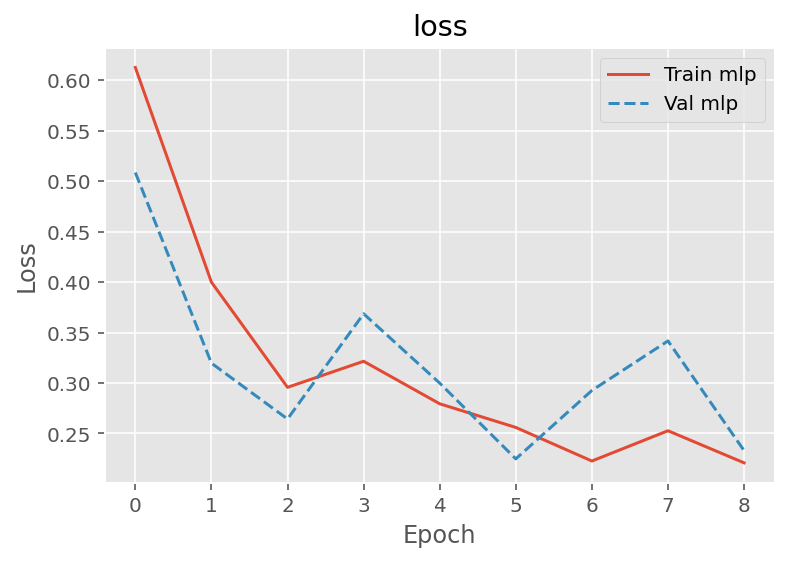

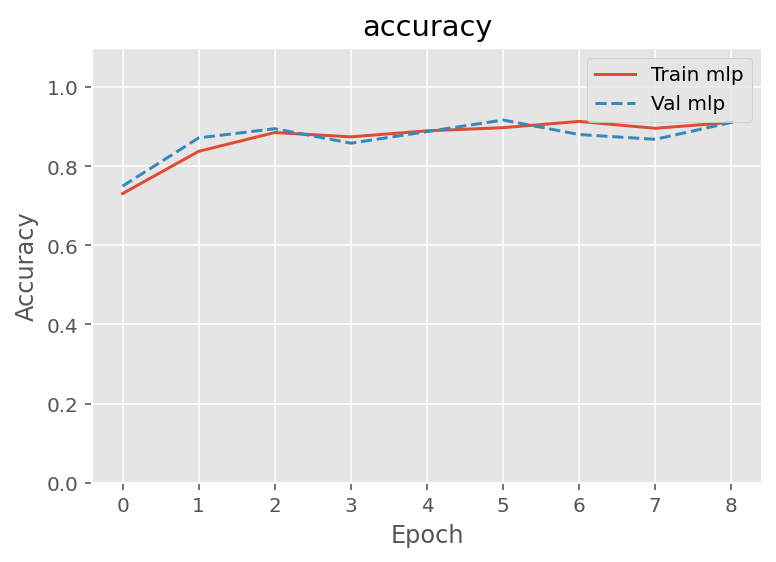

[[194 208]
 [213 205]]
accuracy is : 0.4865853658536585
CPU times: user 53.2 s, sys: 577 ms, total: 53.8 s
Wall time: 49 s


In [33]:
%%time
model3_eval = evaluate_model(model=mlp,train_iter=train_iter,test_iter=test_iter,y_test=y_test,model_name = 'mlp',epochs=20,verbose=1)

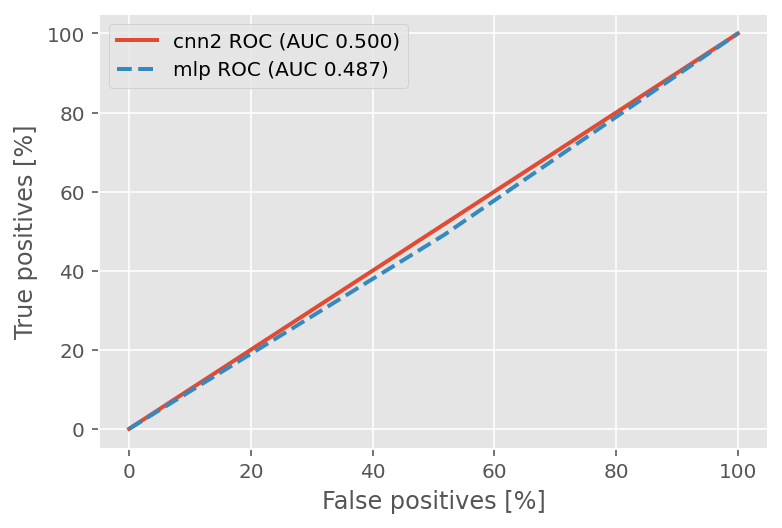

In [34]:
plot_roc(model2_eval,model3_eval,'cnn2','mlp')

## Exceptional Work (1 points total)
- You have free reign to provide additional analyses. 
- One idea (required for 7000 level students): Use transfer learning to pre-train the weights of your initial layers of your CNN. Compare the performance when using transfer learning to training without transfer learning (i.e., compare to your best model from above) in terms of classification performance. 

In [35]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions


cnn4 = Sequential()
cnn4.add(ResNet50(weights = 'imagenet',include_top=False ,pooling='avg'))
cnn4.add(Dense(1, activation = "sigmoid"))

cnn4.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

cnn4.get_layer('resnet50').trainable = False

cnn4.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 2048)              23587712  
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 2049      
Total params: 23,589,761
Trainable params: 2,049
Non-trainable params: 23,587,712
_________________________________________________________________


In [36]:
data_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)
train_iter = data_gen.flow(X_train,y_train,batch_size=32)
test_iter = data_gen.flow(X_test,y_test,batch_size=32)

Epoch 1/10
103/103 [==============================] - 29s 281ms/step - loss: 0.1508 - accuracy: 0.9539 - val_loss: 13.3017 - val_accuracy: 0.9134
Epoch 2/10
103/103 [==============================] - 28s 269ms/step - loss: 0.0504 - accuracy: 0.9838 - val_loss: 0.1844 - val_accuracy: 0.9622
Epoch 3/10
103/103 [==============================] - 28s 268ms/step - loss: 0.0284 - accuracy: 0.9918 - val_loss: 0.0590 - val_accuracy: 0.9841
Epoch 4/10
103/103 [==============================] - 28s 268ms/step - loss: 0.0184 - accuracy: 0.9939 - val_loss: 0.0211 - val_accuracy: 0.9963
Epoch 5/10
103/103 [==============================] - 28s 268ms/step - loss: 0.0387 - accuracy: 0.9881 - val_loss: 3.5125 - val_accuracy: 0.8622
Epoch 6/10
103/103 [==============================] - 28s 268ms/step - loss: 0.0388 - accuracy: 0.9896 - val_loss: 0.0892 - val_accuracy: 0.9707
Epoch 7/10
103/103 [==============================] - 28s 268ms/step - loss: 0.0180 - accuracy: 0.9948 - val_loss: 0.0672 - val_a

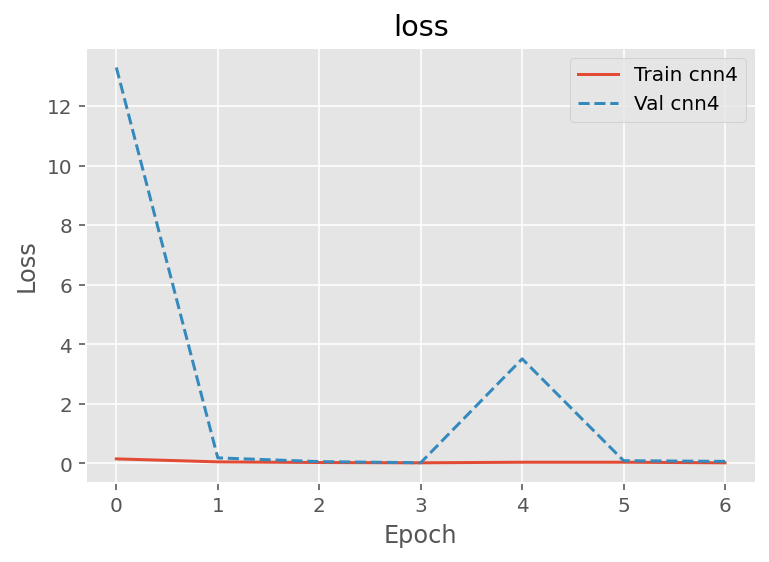

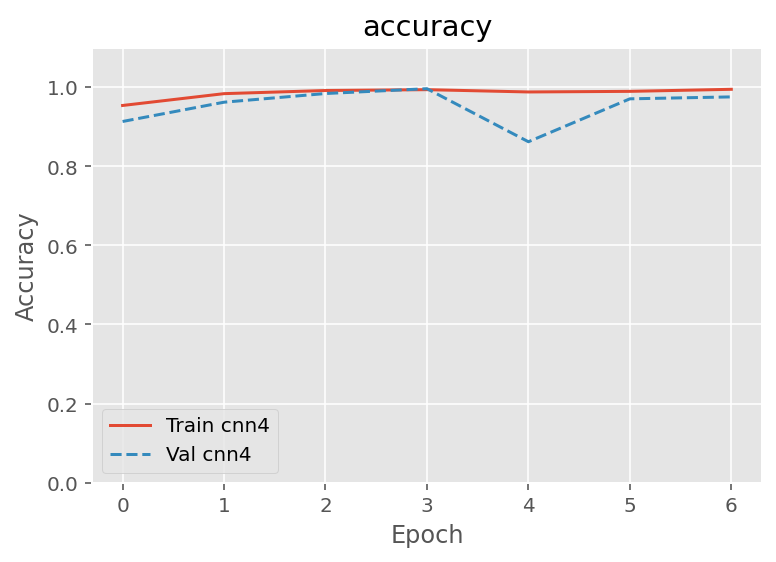

[[205 197]
 [213 205]]
accuracy is : 0.5
CPU times: user 2min 27s, sys: 1.22 s, total: 2min 29s
Wall time: 3min 22s


In [37]:
%%time
model5_eval = evaluate_model(model=cnn4,train_iter=train_iter,test_iter=test_iter,y_test=y_test,model_name = 'cnn4',epochs=20,verbose=1,fit=True)

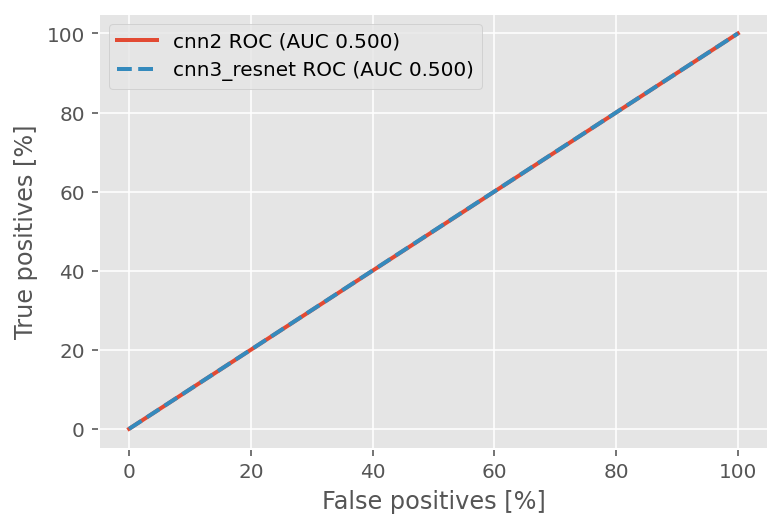

In [38]:
plot_roc(model2_eval,model5_eval,'cnn2','cnn3_resnet')